# Deep Learning - Gesture Recognition Case Study #

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
#Install Few Dependencies if not available and validated versions

#!pip install Pillow
#!pip install imageio
#!pip install scikit-image
#!pip install tensorflow
#!pip install keras
print("*"*30)
print("Versions")
print("*"*30)
!pip freeze | grep 'scipy\|keras\|tensorflow'
!nvidia-smi

******************************
Versions
******************************
horovod @ file:///opt/tensorflow/horovod-source/dist/horovod-0.20.2.tar.gz
scipy==1.4.1
tensorflow @ file:///tmp/pip/tensorflow-2.3.1%2Bnv-cp36-cp36m-linux_x86_64.whl
tensorflow-addons @ file:///opt/tensorflow/tf-addons/artifacts/tensorflow_addons-0.11.2-cp36-cp36m-linux_x86_64.whl
tensorflow-datasets==3.2.1
tensorflow-estimator==2.3.0
tensorflow-metadata==0.25.0
Wed Jul 28 01:23:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+==================

In [2]:
#Import the necessary Libraries

import numpy as np
import os
#from imageio import imread
import scipy
#imgresize is deprecated, use Pillow instead
#numpy.array(Image.fromarray(arr).resize())
#https://docs.scipy.org/doc/scipy-1.2.0/reference/generated/scipy.misc.imresize.html
from skimage.transform import resize
import datetime
import os
from tensorflow import keras
import tensorflow as tf
import random
import glob
import cv2
import matplotlib.pyplot as plt

In [3]:
#Initialize Paths
#help(os)
#print(os.getcwd())
project_folder = '/datasets/Project_data'
train_image_metadata=project_folder+'/train.csv'
val_image_metadata=project_folder+'/val.csv'

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open(train_image_metadata).readlines())
val_doc = np.random.permutation(open(val_image_metadata).readlines())
#batch_size = #experiment with the batch size

In [6]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

/datasets/Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new/*


Text(0.5, 0.98, 'Different Channels of Image')

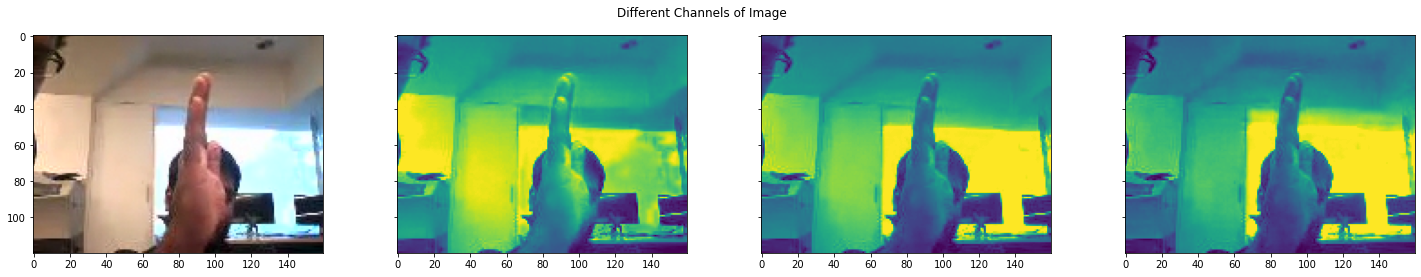

In [7]:
# run this block multiple times to look at some randomly chosen images 
rand_index = random.randint(0, len(train_doc)) # Find a random video folder 
train_path = project_folder+'/train/'+train_doc[rand_index].split(';')[0]+'/*'
print(train_path)
train_path = glob.glob(train_path) # Glob all 30 images of the folder
#print(len(train_path))
rand_index = random.randint(0, len(train_path))
image = cv2.imread(train_path[rand_index]) #Read a random image from the selected folder
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#plt.imshow(image)
#plt.show()
#image.shape
# plotting the  image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(25)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')


(120, 160, 3)


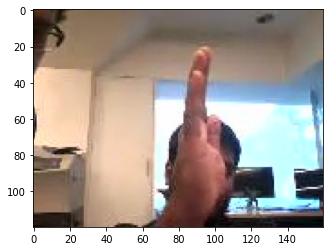

In [8]:
print(image.shape)
#crop_image=image[0:120,20:140]

plt.imshow(image)
plt.show()

(120, 120, 3)


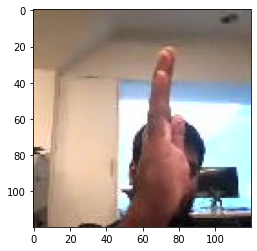

In [9]:
crop_image=image[0:120,20:140]
print(crop_image.shape)
plt.imshow(crop_image)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


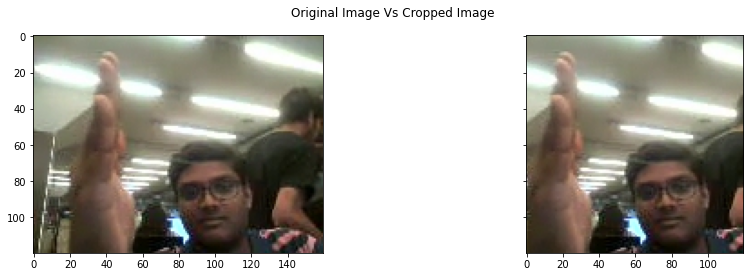

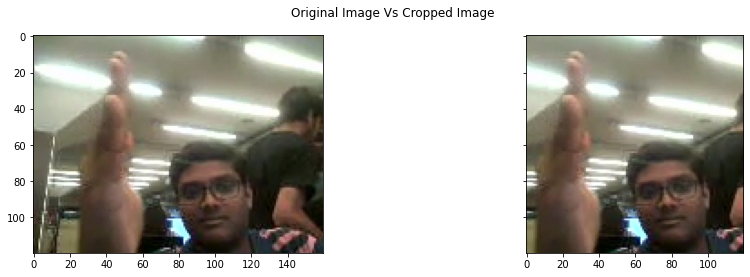

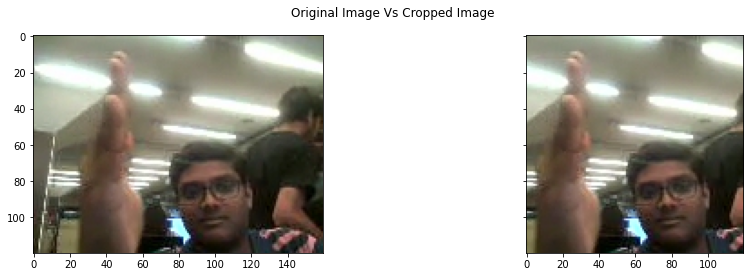

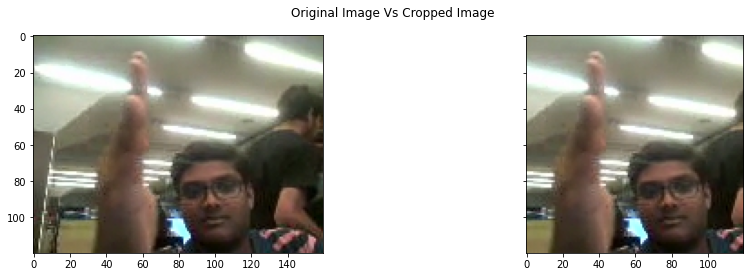

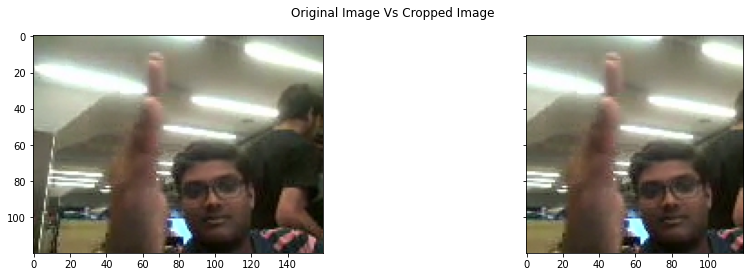

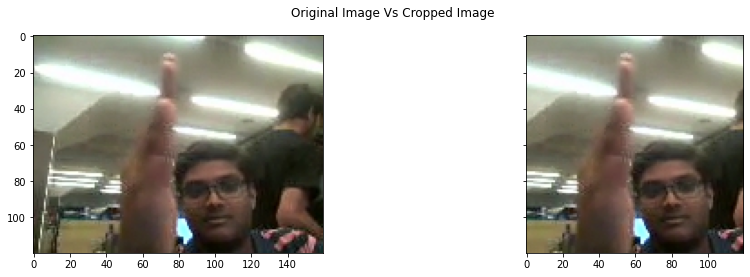

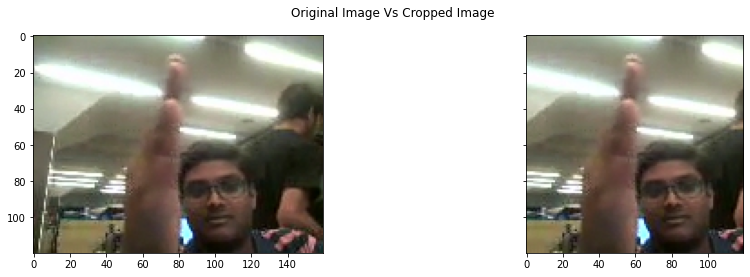

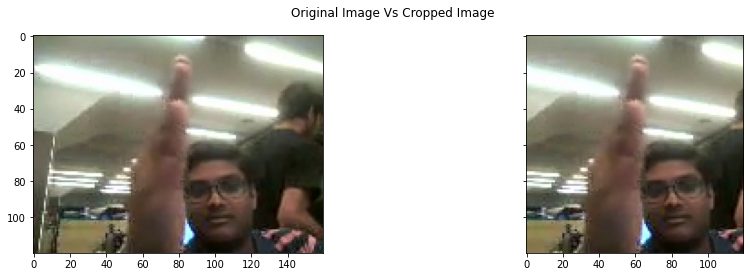

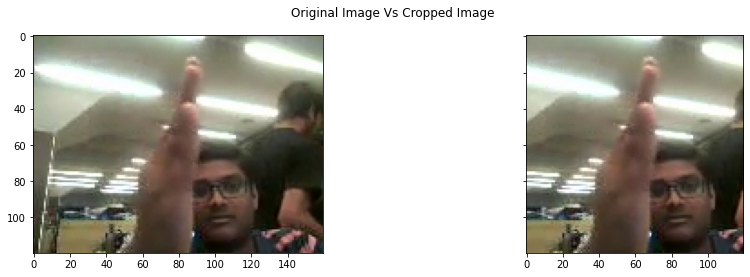

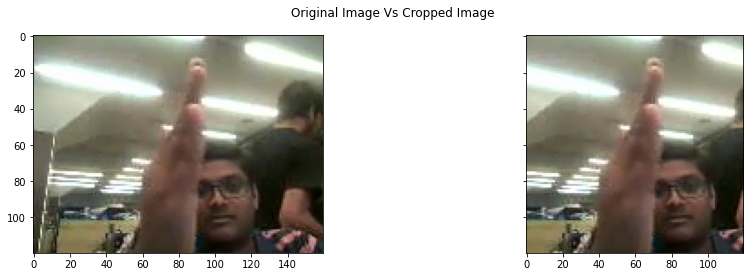

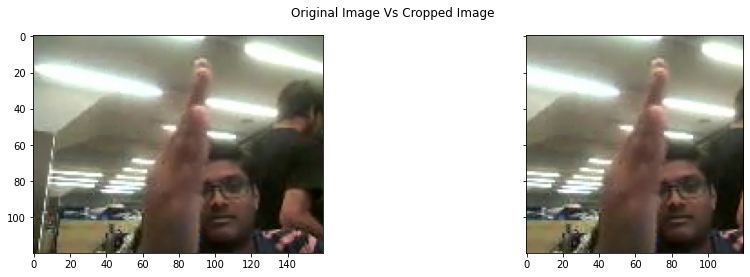

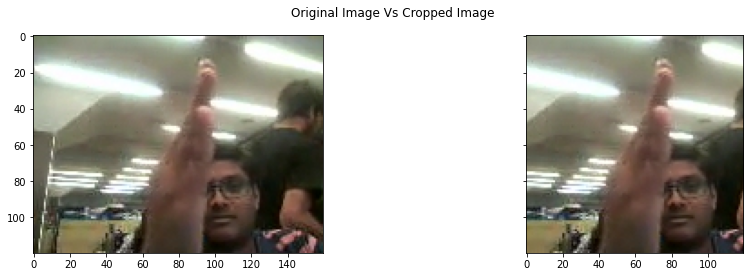

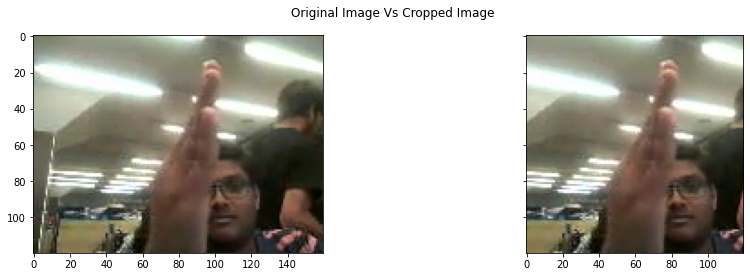

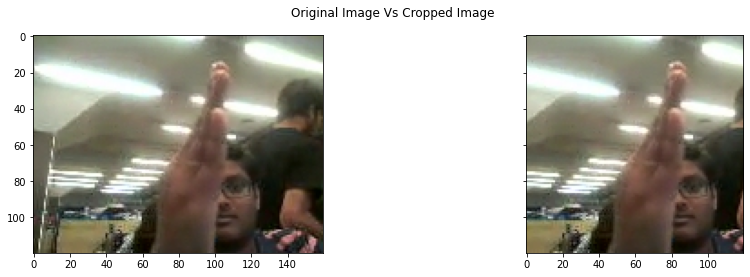

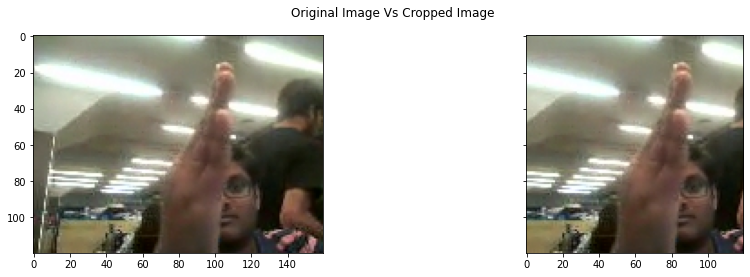

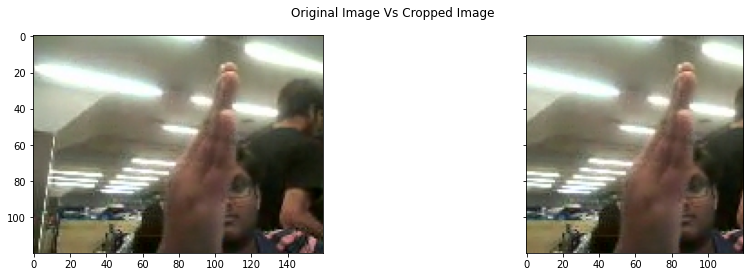

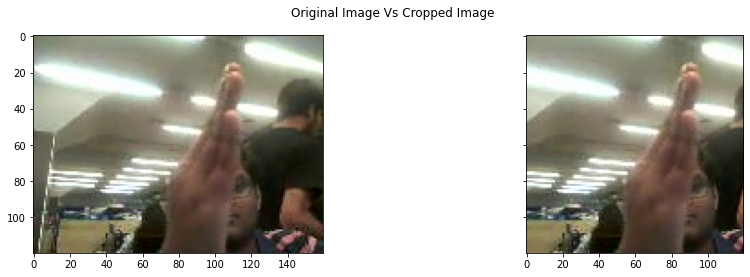

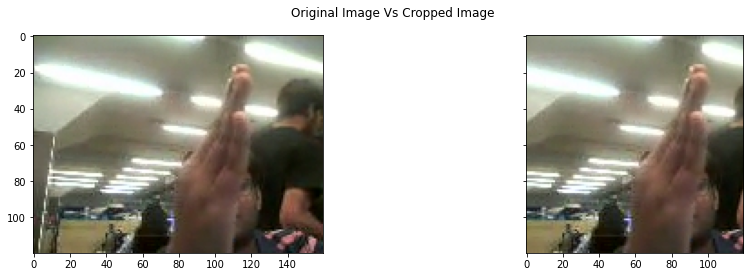

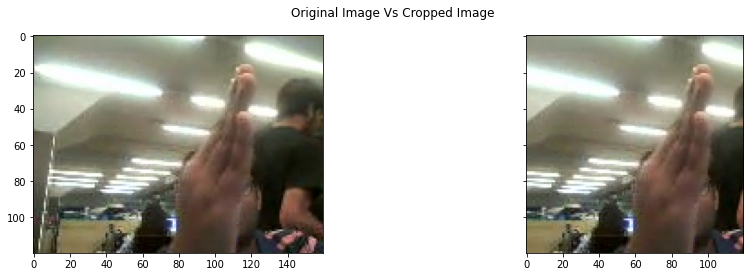

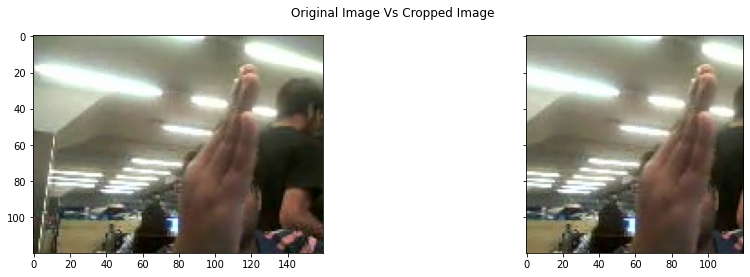

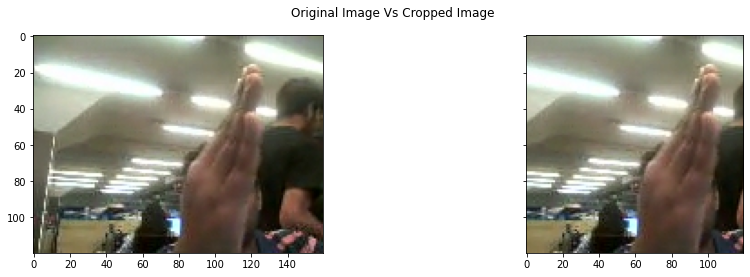

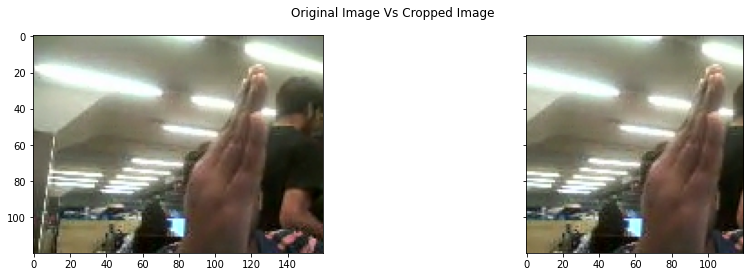

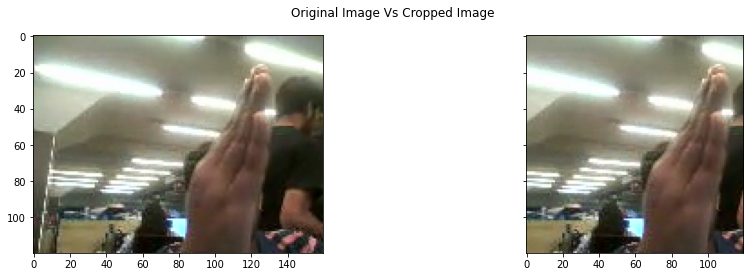

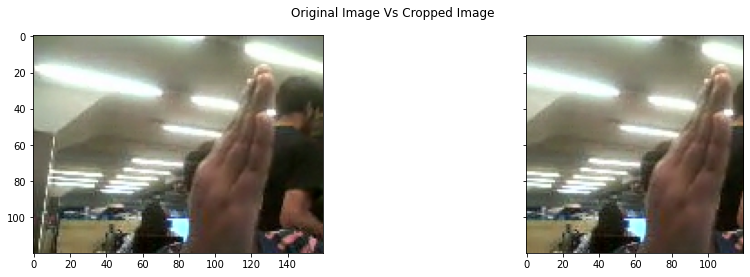

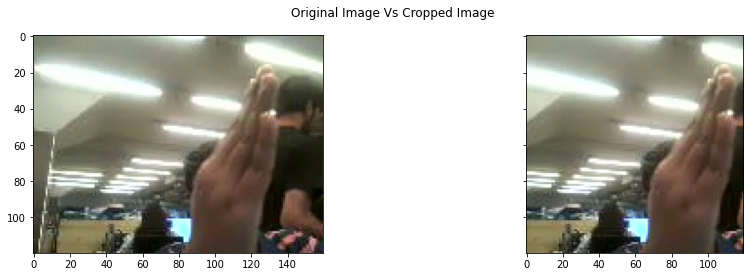

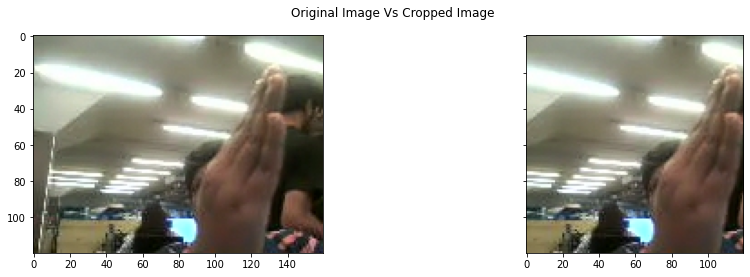

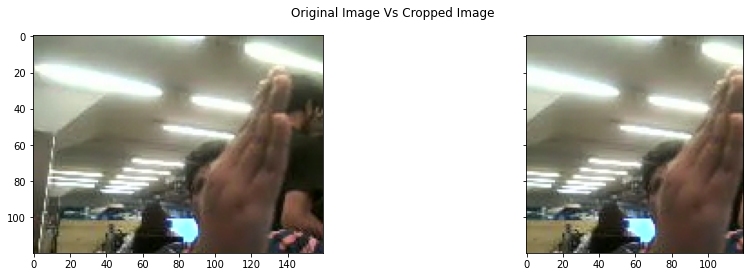

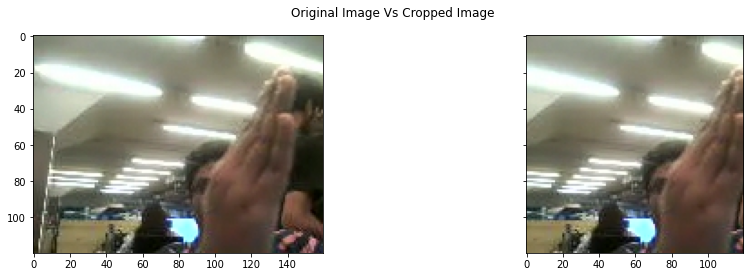

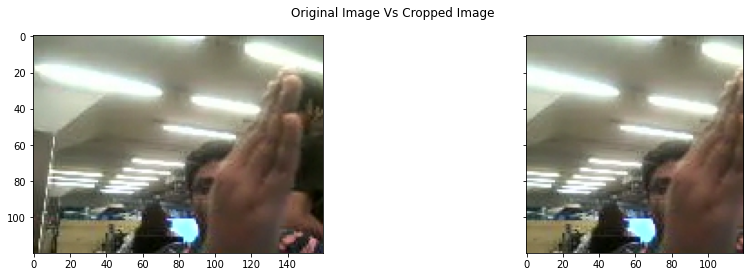

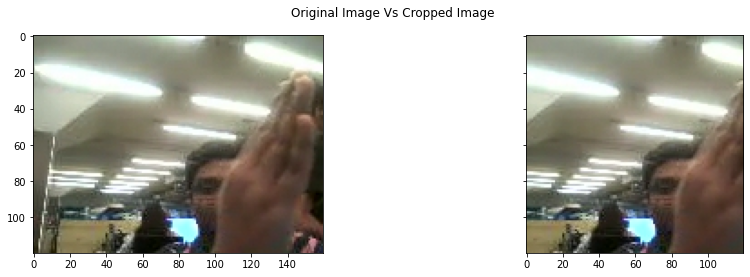

In [10]:
fliplr_thumbdown_path = glob.glob('/datasets/Project_data/train/WIN_20180925_17_57_52_Pro_Thumbs_Down_new/*')
fliplr_thumbup_path= glob.glob('/datasets/Project_data/train/WIN_20180925_17_22_42_Pro_Thumbs_Up_new/*')
fliplr_rightswipe_path=glob.glob('/datasets/Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new/*')
fliplr_leftswipe_path=glob.glob('/datasets/Project_data/train/WIN_20180926_16_48_34_Pro_Left_Swipe_new/*')
crop_left_swipe = glob.glob('/datasets/Project_data/train/WIN_20180925_17_40_41_Pro_Left_Swipe_new/*')
#for path in crop_left_swipe:
#    image = cv2.imread(path) #Read a random image from the selected folder
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    f.set_figwidth(15)
#    ax1.imshow(image)
#    ax2.imshow(image[0:120,20:140])
#    f.suptitle('Original Image Vs Cropped Image')
    
    
#plt.close('all')
#plt.clf()

(120, 160, 3)


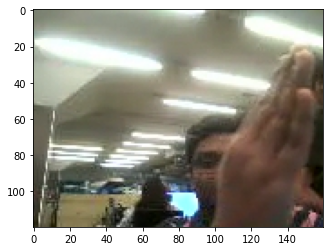

[[ 1.  0.  6.]
 [ 0.  1. 12.]]
Shifted (120, 160, 3)


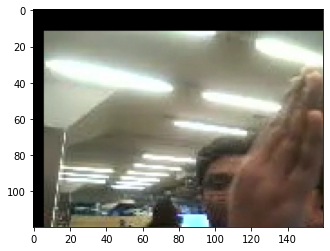

Rotated [[  0.9781476   -0.20791169  14.222894  ]
 [  0.20791169   0.9781476  -15.321792  ]]
Rotated (120, 160, 3)


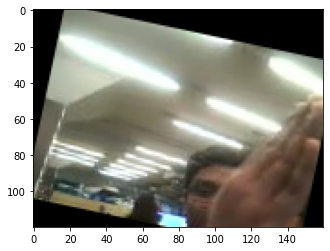

(120, 160)


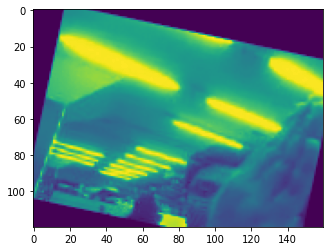

(119, 159, 3)


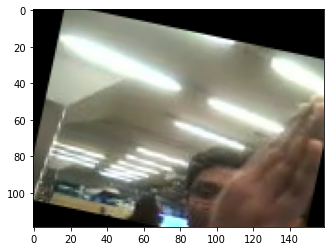

(120, 120, 3)


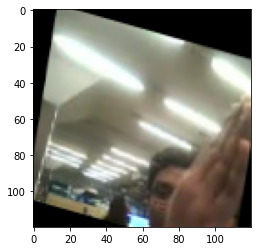

In [11]:
print(image.shape)
plt.imshow(image)
plt.show()
#crop_image=image[0:120,20:140]
#print(crop_image.shape)
#plt.imshow(crop_image)
#plt.show()
#new_image = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
#print(new_image.shape)
#plt.imshow(new_image)
#plt.show()
#image_resized=resize(image,(120,120,3))
#print(image_resized.shape)
#plt.imshow(image_resized)
#plt.show()
rows, cols = image.shape[:2]
 
# #https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b
#Then we’ll build a transformation matrix that will contain the information to transform the image. 
#For simplification, we can think of this matrix as    
    
#[[size, rotation, location], ←x-axis
#[rotation, size, location]] ←y-axis
# So default matrix will be
#[[1, 0, 0]
# [0, 1, 0]]
#That means, 100% of the size, zero rotation, and no change in the location 

# build a transformation matrix for changing location
matrix = [[1, 0, np.random.randint(-30,30)], #x 
          [0, 1, np.random.randint(-30,30)]] #y
M = np.float32(matrix)

print(M)
# Apply the affine transformation using cv2.warpAffine()
shifted = cv2.warpAffine(image, M, (cols,rows))

print("Shifted",shifted.shape)
plt.imshow(shifted)
plt.show()

# build a transformation matrix for rotation
#rot_matrix = [[1, 10, 0], #x 
#          [10, 1, 0]] #y


rot_matrix = cv2.getRotationMatrix2D((cols//2,rows//2),
                                                np.random.randint(-20,20), 1)
rot_M = np.float32(rot_matrix)


print("Rotated",rot_M)
# Apply the affine transformation using cv2.warpAffine()
rotated = cv2.warpAffine(shifted, rot_M, (cols,rows))
print("Rotated",rotated.shape)
plt.imshow(rotated)
plt.show()

gray = cv2.cvtColor(rotated,cv2.COLOR_RGB2GRAY)
print(gray.shape)
plt.imshow(gray)
plt.show()

x0, y0 = np.argwhere(gray > 0).min(axis=0)
x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                  
cropped=rotated[x0:x1,y0:y1,:]
print(cropped.shape)
plt.imshow(cropped)
plt.show()

new_image = cv2.resize(cropped, (120,120), interpolation = cv2.INTER_AREA)
print(new_image.shape)
plt.imshow(new_image)
plt.show()





### Results Plotter ###

In [12]:
#Use the history object to plot the results

def plot(history):
    fig,axes = plt.subplots(nrows=1,ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:
#Base Class for all the classes with common functionality
import abc
class BaseModel(metaclass=abc.ABCMeta):
    
    #initialize the path for the train and validation images
    #This will be called by each inherited class
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(train_image_metadata).readlines())
        self.val_doc = np.random.permutation(open(val_image_metadata).readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    
    #initialize the properties of each image
    #We will standardize all image using the 
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    #initalize the training parameters, this will be used by  each model to train 
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def generator(self, source_path, folder_list, augment=False):
        batch_size = self.batch_size
        #print('Source path = ', source_path)
        #print('batch size =', batch_size)
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            #print("t : ", t)
            num_batches =  len(t)//batch_size
            #print("num_batches", num_batches)
            
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels= self.one_batch_data_generator(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 
                
            
            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data_generator(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
                
                
    
    def one_batch_data_generator(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        
        #Initialize the seq length
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_len,self.num_classes)) # batch_labels is the one hot representation of the output

        
        if (augment): 
            batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
            batch_data_rot = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        
        for folder in range(seq_len): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    # 360 x 360 and 120 x 160 and 
                    # the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Crop the image which doesn't have aspect ratio of 1
                    # In the data set 120x160 will be those, we will adjust the width by trimming
                    # 20 pixels from both left and right side and making it a 120x120 image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                        
                    #As we are shrinking the image so using Interpolation as "INTER_AREA"
                    image_resized = cv2.resize(image, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
           
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    if (augment):
                        # #https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b
                        #We’ll build a transformation matrix that will contain the information to 
                        #transform the image. 
                        #For simplification, we can think of this matrix as    
    
                        #[[size, rotation, location], ←x-axis
                        #[rotation, size, location]] ←y-axis
                        # So default matrix will be
                        #[[1, 0, 0]
                        # [0, 1, 0]]
                        #That means, 100% of the size, zero rotation, and no change in the location 

                        # build a transformation matrix
                        # We will do random location change in the range of -30 to 30 for both x and y axis
                        translation_matrix = np.array([
                                 [1, 0, np.random.randint(-30,30)], #x 
                                 [0, 1, np.random.randint(-30,30)]  #y
                        ], dtype=np.float32) 
                                                
                        rows, cols = image.shape[:2] # Height, Width
                        # Apply the affine transformation using cv2.warpAffine()
                        # cv2 needs dimensions in Width, Height formats
                        transformed = cv2.warpAffine(image, translation_matrix, (cols,rows))
                        
                        #Convert to grayscale to crop out black borders if any
                        gray = cv2.cvtColor(shifted,cv2.COLOR_RGB2GRAY)

                        # Find min and max from pixels whose intensity is not zero.
                        # Black will be zero
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                        cropped=transformed[x0:x1,y0:y1,:]
                    
                        image_resized = cv2.resize(cropped, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
                      
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                        
                        #Rotate image at an angle between -10 to 10 
                        rotate_matrix = cv2.getRotationMatrix2D((cols//2,rows//2),
                                                np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image, rotate_matrix, (cols, rows)) 
                        
                        rotated_resized = cv2.resize(rotated, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
                        
                        batch_data_rot[folder,idx,:,:,0] = (rotated_resized[:,:,0])/255
                        batch_data_rot[folder,idx,:,:,1] = (rotated_resized[:,:,1])/255
                        batch_data_rot[folder,idx,:,:,2] = (rotated_resized[:,:,2])/255
                                               
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        #Add to the augmentated labels also if augmented is true
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_data=np.concatenate([batch_data,batch_data_rot])
            batch_labels=np.tile(batch_labels,(3,1)) # Create Label by repeating the batch_label 3 times
            

        return (batch_data, batch_labels)
    
    def train_model(self, model, augment_data = False):
        train_generator = self.generator(self.train_path, self.train_doc, augment= augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        
        if not os.path.exists(model_name):
            os.mkdir(model_name)
            
        filepath = 'model_init' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}--{val_categorical_accuracy:.5f}.h5'
        
        #HyperParameter Tuners
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', min_dela=0, patience=5, verbose=1)
        earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)
        
        callbacks_list = [checkpoint, LR, earlystop]
        
        #The `steps_per_epoch` and `validation_steps` are used by 
        #fit_generator to decide the number of next() calls it need to make.
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history   
    
    @abc.abstractmethod
    def define_model(self):
        pass   

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Modelling Iterations
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
#Common Import for Models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers



### Initial Model : 1

In [15]:
class ModelConv3D_Inital(BaseModel):
    
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Assembling Model 1:

In [16]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=1)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 160, 160, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 16, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 80, 80, 32)     128       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 80, 80, 32)     0

In [17]:
conv3d_initial.train_model(conv3d_initial_model)

23/23 [==============================] - ETA: 0s - loss: 1.9414 - categorical_accuracy: 0.3243
Epoch 00001: val_loss improved from inf to 2.59406, saving model to model_initmodel-00001-1.94137-0.32428-2.59406--0.16000.h5
23/23 [==============================] - 38s 2s/step - loss: 1.9414 - categorical_accuracy: 0.3243 - val_loss: 2.5941 - val_categorical_accuracy: 0.1600


In [18]:
conv3d_initial_overfit = ModelConv3D_Inital()
conv3d_initial_overfit.initialize_path(project_folder)
conv3d_initial_overfit.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial_overfit.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
conv3d_initial_overfit_model = conv3d_initial_overfit.define_model()
conv3d_initial_overfit_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 160, 160, 16)  64        
_________________________________________________________________
activation_4 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 80, 80, 32)     128       
_________________________________________________________________
activation_5 (Activation)    (None, 8, 80, 80, 32)    

In [19]:
conv3d_initial_overfit.train_model(conv3d_initial_overfit_model)

Epoch 1/20
22/23 [===========================>..] - ETA: 1s - loss: 1.8258 - categorical_accuracy: 0.3803
Epoch 00001: val_loss improved from inf to 2.29989, saving model to model_initmodel-00001-1.82654-0.38009-2.29989--0.17000.h5
23/23 [==============================] - 39s 2s/step - loss: 1.8265 - categorical_accuracy: 0.3801 - val_loss: 2.2999 - val_categorical_accuracy: 0.1700
Epoch 2/20
22/23 [===========================>..] - ETA: 1s - loss: 1.1861 - categorical_accuracy: 0.5561
Epoch 00002: val_loss did not improve from 2.29989
23/23 [==============================] - 38s 2s/step - loss: 1.1881 - categorical_accuracy: 0.5551 - val_loss: 3.4190 - val_categorical_accuracy: 0.2200
Epoch 3/20
22/23 [===========================>..] - ETA: 1s - loss: 0.9866 - categorical_accuracy: 0.6439
Epoch 00003: val_loss did not improve from 2.29989
23/23 [==============================] - 37s 2s/step - loss: 0.9834 - categorical_accuracy: 0.6456 - val_loss: 5.3022 - val_categorical_accuracy: 0.

### With Augmented Data and 20 epoch
### Batch size 30 gave out of memory error on GPU, so setting to 10

In [20]:
conv3d_initial_augment = ModelConv3D_Inital()
conv3d_initial_augment.initialize_path(project_folder)
conv3d_initial_augment.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial_augment.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=20)
conv3d_initial_augment_model = conv3d_initial_augment.define_model()
conv3d_initial_augment_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
activation_8 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 80, 80, 32)     128       
_________________________________________________________________
activation_9 (Activation)    (None, 8, 80, 80, 32)    

In [21]:

conv3d_initial_augment.train_model(conv3d_initial_augment_model, augment_data=True)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.9511 - categorical_accuracy: 0.3293
Epoch 00001: val_loss improved from inf to 2.55842, saving model to model_initmodel-00001-1.95108-0.32931-2.55842--0.16000.h5
67/67 [==============================] - 93s 1s/step - loss: 1.9511 - categorical_accuracy: 0.3293 - val_loss: 2.5584 - val_categorical_accuracy: 0.1600
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.4832 - categorical_accuracy: 0.4595
Epoch 00002: val_loss did not improve from 2.55842
67/67 [==============================] - 92s 1s/step - loss: 1.4832 - categorical_accuracy: 0.4595 - val_loss: 3.1912 - val_categorical_accuracy: 0.2000
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.2832 - categorical_accuracy: 0.5173
Epoch 00003: val_loss did not improve from 2.55842
67/67 [==============================] - 93s 1s/step - loss: 1.2832 - categorical_accuracy: 0.5173 - val_loss: 2.6278 - val_categorical_accuracy: 0.

### Let's try reducing the dimensions to 120 x 120

In [22]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=120, image_width=120)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=1)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
activation_13 (Activation)   (None, 8, 60, 60, 32)    

In [23]:
conv3d_initial.train_model(conv3d_initial_model)

23/23 [==============================] - ETA: 0s - loss: 1.9161 - categorical_accuracy: 0.3620
Epoch 00001: val_loss improved from inf to 1.79449, saving model to model_initmodel-00001-1.91613-0.36199-1.79449--0.26000.h5
23/23 [==============================] - 31s 1s/step - loss: 1.9161 - categorical_accuracy: 0.3620 - val_loss: 1.7945 - val_categorical_accuracy: 0.2600


### Let's try reducing the dimensions to 80 x 80

In [26]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=80, image_width=80)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 80, 80, 16)    1312      
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 80, 80, 16)    64        
_________________________________________________________________
activation_20 (Activation)   (None, 16, 80, 80, 16)    0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 40, 40, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 40, 40, 32)     4128      
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 40, 40, 32)     128       
_________________________________________________________________
activation_21 (Activation)   (None, 8, 40, 40, 32)    

In [27]:
conv3d_initial.train_model(conv3d_initial_model)

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.9447 - categorical_accuracy: 0.3801
Epoch 00001: val_loss improved from inf to 1.84139, saving model to model_initmodel-00001-1.94473-0.38009-1.84139--0.16000.h5
23/23 [==============================] - 31s 1s/step - loss: 1.9447 - categorical_accuracy: 0.3801 - val_loss: 1.8414 - val_categorical_accuracy: 0.1600
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.4016 - categorical_accuracy: 0.4932
Epoch 00002: val_loss did not improve from 1.84139
23/23 [==============================] - 31s 1s/step - loss: 1.4016 - categorical_accuracy: 0.4932 - val_loss: 3.0740 - val_categorical_accuracy: 0.1800
Epoch 3/3
22/23 [===========================>..] - ETA: 1s - loss: 1.2333 - categorical_accuracy: 0.5455
Epoch 00003: val_loss did not improve from 1.84139
23/23 [==============================] - 31s 1s/step - loss: 1.2296 - categorical_accuracy: 0.5460 - val_loss: 4.2846 - val_categorical_accuracy: 0.170

#### With Augmentation

In [28]:
conv3d_initial.train_model(conv3d_initial_model, True)

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5676 - categorical_accuracy: 0.4791
Epoch 00001: val_loss improved from inf to 3.48925, saving model to model_initmodel-00001-1.56764-0.47914-3.48925--0.23000.h5
23/23 [==============================] - 58s 3s/step - loss: 1.5676 - categorical_accuracy: 0.4791 - val_loss: 3.4892 - val_categorical_accuracy: 0.2300
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.3211 - categorical_accuracy: 0.5334
Epoch 00002: val_loss did not improve from 3.48925
23/23 [==============================] - 57s 2s/step - loss: 1.3211 - categorical_accuracy: 0.5334 - val_loss: 4.5280 - val_categorical_accuracy: 0.2200
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.1027 - categorical_accuracy: 0.5832
Epoch 00003: val_loss did not improve from 3.48925
23/23 [==============================] - 57s 2s/step - loss: 1.1027 - categorical_accuracy: 0.5832 - val_loss: 4.7608 - val_categorical_accuracy: 0.160